<a href="https://colab.research.google.com/github/Alvaisari/photoionization-cross-sections/blob/main/photoionization_cross_section.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center><div style='font-family: "serif"'> Photoionization cross-section </div></center>

<p style='font-size: 16px;', align="justify">
The photoionization cross-section $\sigma$ is a measure for the probability of a photon to excite a specific transition. It is element and subshell specific. The bigger $\sigma$ the higher the measured intensity of the respective transition in XPS.
<br><br>
You can obtain $\sigma$ in Mbarn ($10^{–28}$m$^2$) based on your data using code below. The source of data is https://vuo.elettra.eu/. In general, code will return linear interpolation between closest points to user input.

The available range of experimental data is limited by $E_{ph}=1500$ eV. If user input exceeds this range, experimental datapoints are approximated by log-exp function:

$$y = exp(a ⋅ log(x) + b)$$

[INFO] Reached vuo.elettra.eu


,Eph [eV],Sigma [MBarn]
0,365.0,1.208667
1,700.0,0.215533
2,1800.0,0.062313


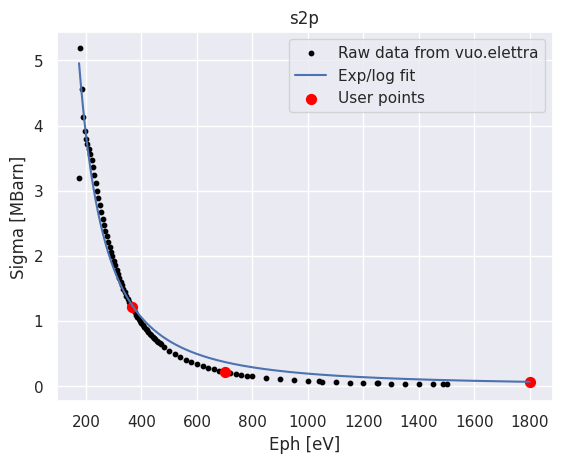

In [1]:
import numpy as np
from scipy.optimize import curve_fit
from google.colab import files  # way to upload/download files
import pandas as pd             # way to read csv and xlsx
import os
import sys
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")


def fitCurve(x, y, newx):
    """

    """
    # define the true objective function
    def objective(x, a, b):
        return np.exp(a*np.log(x) + b)

    # get optimal parameter values
    popt, _ = curve_fit(objective, x, y)
    a, b = popt
    return objective(newx, a, b)

#@markdown Specify element core level
lvl = "s2p" #@param {type:"string"}

#@markdown Check the box if you want to upload your xlsx file and run the cell.
#@markdown It must contain "Eph [eV]" column, where Eph $-$ photon energy.
Upload_file = False #@param {type:"boolean"}

#@markdown Or enter required Eph values in the field below separating values by space
#@markdown and then run the cell
Eph = "365 700 1800" #@param {type:"string"}

#@markdown If you have accidentaly unfolded the code, double click on blank field

try:
  cros_sec = pd.read_csv(
      f'https://vuo.elettra.eu/services/elements/data/{lvl.lower()}.txt',
      delimiter='\t',
      header=None,
      usecols=[0, 1, 2, 3]
      )
  # add averaged values of cross section
  cros_sec.rename(columns={0: r'Eph [eV]'}, inplace=True)
  cros_sec['averaged'] = (cros_sec[1] + cros_sec[2] + cros_sec[3]) / 3
  print('[INFO] Reached vuo.elettra.eu')
except Exception as e:
  print(f'[ERROR] {e}')

if Upload_file:
    uploaded = files.upload()            # propose to upload file
    filename = next(iter(uploaded))      # retrieve filename
    user_data = pd.read_excel(filename)  # data from excel file
    ## check the Eph range
    if user_data['Eph [eV]'].min() < cros_sec['Eph [eV]'].min():
      sys.exit('Eph is lower than binding energy')
    user_data['Sigma [MBarn]'] = np.nan # create an empty raw
    ## fit datapoint from vuo.elettra.eu
    user_data['Sigma [MBarn]'][user_data['Eph [eV]'] > 1500] = fitCurve(
        cros_sec['Eph [eV]'],
        cros_sec['averaged'],
        user_data['Eph [eV]'][user_data['Eph [eV]'] > 1500]
        )
    user_data['Sigma [MBarn]'][user_data['Eph [eV]'] <= 1500] = \
      np.interp(
          user_data['Eph [eV]'][user_data['Eph [eV]'] <= 1500],
          cros_sec['Eph [eV]'],
          cros_sec['averaged']
          )

    ## save fitted data to excel file
    user_data.to_excel(
        f'new_{filename}',
        index=False
        )
    files.download(f'new_{filename}') # download file
    os.remove(filename)                # delete uploaded file
else:
    try:
      user_data = pd.DataFrame()
      user_data['Eph [eV]'] = [float(i) for i in Eph.replace(',', '.').split()]
      ## check the Eph range
      if user_data['Eph [eV]'].min() < cros_sec['Eph [eV]'].min():
        sys.exit('Eph is lower than binding energy')
      user_data['Sigma [MBarn]'] = np.nan # create an empty raw
      user_data['Sigma [MBarn]'][user_data['Eph [eV]'] > 1500] = fitCurve(
        cros_sec['Eph [eV]'],
        cros_sec['averaged'],
        user_data['Eph [eV]'][user_data['Eph [eV]'] > 1500]
        )
      user_data['Sigma [MBarn]'][user_data['Eph [eV]'] <= 1500] = \
      np.interp(
          user_data['Eph [eV]'][user_data['Eph [eV]'] <= 1500],
          cros_sec['Eph [eV]'],
          cros_sec['averaged']
          )

      display(user_data)
    except ValueError as e:
      sys.exit(f'[ERROR] {e}. Check the Eph input')


fig, ax = plt.subplots()
cros_sec.plot.scatter(
    x='Eph [eV]',
    y='averaged',
    ax=ax,
    color='black',
    s=10,
    label='Raw data from vuo.elettra'
    )

x_fitted_curve = np.arange(
    cros_sec['Eph [eV]'].min(),
    user_data['Eph [eV]'].max(),
    1
    )
y_fitted_curve = fitCurve(
    cros_sec['Eph [eV]'],
    cros_sec['averaged'],
    x_fitted_curve
    )
ax.plot(
    x_fitted_curve,
    y_fitted_curve,
    label='Exp/log fit'
)

user_data.plot.scatter(
    x='Eph [eV]',
    y='Sigma [MBarn]',
    ax=ax,
    color='red',
    s=50,
    label='User points'
    )
plt.title(lvl)
plt.legend();